In [1]:
# import os
import gc
import random
import timm
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts #, ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint , EarlyStopping

import wandb
import albumentations as A
from torchtoolbox.tools import mixup_data, mixup_criterion
import soundfile as sf
from sklearn import *
import pickle

import warnings
warnings.filterwarnings('ignore')


In [2]:

# Define a config dictionary object
config = {
    'use_aug': False,
    'num_classes': 264,
    'PRECISION': 16,    
    'PATIENCE': 10,    
    'seed': 2023,
    'pretrained': True,            
    'weight_decay': 1e-3,   
    'DEVICE': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),    
    'data_root': './',   
    'SR': 32000,
    'DURATION': 5,
    'MAX_READ_SAMPLES': 5,
    'save_path': './exp1/',
    'bird_name_path': 'bird_names.pickle3',
    'mel_file_path': 'train_mel(dB,sr=32k,bin=128).pickle3',
    'mfcc_file_path': 'train_mfcc(n=20).pickle3',
    'chroma_file_path': 'train_chroma(k=12).pickle3',
    'verbose':False,
    'random_state':42,
    'k_fold': 5,
    'val_fold_idx':0,
    'LR': 5e-4,
    'use_mixup': True,
    'mixup_alpha': 0.2,
    'batch_size': 64,
    'epochs': 10,
    'model': 'tf_efficientnet_b2_ns',
    'exp_name':'base'
}

# Pass the config dictionary when you initialize W&B
wandb.init(project="Bird", config=config, name='base')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yuhaoliu (iccd). Use `wandb login --relogin` to force relogin


In [3]:
pl.seed_everything(wandb.config['seed'], workers=True)

Global seed set to 2023


2023

In [4]:
def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out


In [5]:

def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=wandb.config['weight_decay']
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=wandb.config['epochs'], 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [6]:
class MyDataset(Dataset):
    def __init__(self, data, mode, data_indices=None, k_fold=wandb.config['k_fold'], val_fold_idx=0, random_state=42):
        assert mode in ['train',  'val'], f'invalid mode {mode}!, mode must be [train | val]'
        self.mode = mode

        self.name_label_2_int_label = load_pickle("name_label_2_int_label.pickle3")  # a dict which saves mapping from

        self.data = data
        self.prefix = list(data.keys())[-3]
        self.val_fold_idx = val_fold_idx
        self.random_state = random_state

        self.k_fold = k_fold

        if data_indices is None:
            data_indices = list(range(data['primary_label_idx']))
            random.seed(self.random_state)
            random.shuffle(data_indices)

        self.val_indices = data_indices[self.val_fold_idx*len(data_indices)//self.k_fold: (self.val_fold_idx+1)*len(data_indices)//self.k_fold]  # 分为k_fold份，第val_fold_idx子份作为验证集
        self.train_indices = [idx for idx in data_indices if idx not in self.val_indices]  # 其余作为训练集

        train_labels = [data['primary_label'][i] for i in self.train_indices]
        val_labels = [data['primary_label'][i] for i in self.val_indices]
        missing_labels = list(set(val_labels)-set(train_labels)) # labels in val set but not in train set

        val_indices_copy = self.val_indices.copy()
        for i, val_idx in enumerate(val_indices_copy):
            if data['primary_label'][val_idx] in missing_labels:  # if a sample's label is in val set but not in train set
                self.train_indices.append(self.val_indices.pop(i))  # then we shift it from val set to train set

    def __getitem__(self, index):

        if self.mode == 'train':
            feat_inp = self.data[self.prefix][self.train_indices[index]]
            label = torch.tensor(self.data['primary_label_idx'][self.train_indices[index]])
            # label = self.name_label_2_int_label[self.label[index]]  # 'bird name' -> idx

        elif self.mode == 'val':
            feat_inp = self.data[self.prefix][self.val_indices[index]]
            label = torch.tensor(self.data['primary_label_idx'][self.val_indices[index]])

        feat_inp = self.crop_or_pad(feat_inp)
        feat_inp = self.normalize(feat_inp)
        feat_inp = torch.from_numpy(feat_inp).unsqueeze(0).float()
        feat_inp = feat_inp.repeat(3,1,1)
        label = torch.nn.functional.one_hot(label, num_classes=264).float()

        return feat_inp, label



    def __len__(self):
        if self.mode == 'train':
            return len(self.train_indices)
        elif self.mode == 'val':
            return len(self.val_indices)
        
    def crop_or_pad(self, m, th=313):  # 313=5s*32000Hz/512
        length = m.shape[1]
        if length <= th: # pad short
            while m.shape[1] < th:  # repeat padding until th
                m = np.concatenate([m, m],axis=1)
            m = m[:,0:th]
        else:  # crop longer audio
            start = np.random.randint(length - th)
            m = m[:,start:start+th]
        return m #torch.from_numpy(m).unsqueeze(0)

    def normalize(self, X, eps=1e-6, mean=None, std=None):
        mean = mean or X.mean()
        std = std or X.std()
        X = (X - mean) / (std + eps)
        
        _min, _max = X.min(), X.max()

        if (_max - _min) > eps:
            V = np.clip(X, _min, _max)
            V = (V - _min) / (_max - _min)
        else:
            V = np.zeros_like(X)

        return V
    

In [7]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=wandb.config['model'], num_classes = wandb.config['num_classes'], pretrained = wandb.config['pretrained']):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        self.model_name = model_name
        
        if 'efficientnet' in model_name or 'mobilenet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes),
                nn.Dropout(0.4),
                nn.Linear(self.num_classes, num_classes))
        elif 'convnext' in model_name:
            self.in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Sequential(
                nn.Linear(self.in_features, num_classes),
                nn.Dropout(0.4),
                nn.Linear(self.num_classes, num_classes))
        elif 'swin' in model_name:
            self.in_features = self.backbone.head.in_features
            self.backbone.head =  nn.Linear(self.in_features, num_classes)
        
        else:
            raise('No valid model name')
                
        self.loss_function = nn.BCEWithLogitsLoss()
        self.global_acc = 0 

    def forward(self,images):
        if 'swin' in self.model_name:
            # for mel data, the original data size (h & w) is [128, 313]
            images = F.interpolate(images, (224, 224))

        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=wandb.config['LR'], params=self.parameters())

    def train_with_mixup(self, X, y):
        X, y_a, y_b, lam = mixup_data(X, y, alpha=wandb.config['mixup_alpha'])
        y_pred = self(X)
        loss_mixup = mixup_criterion(F.cross_entropy, y_pred, y_a, y_b, lam)
        return loss_mixup

    def training_step(self, batch, batch_idx):
        image, target = batch        
        if wandb.config['use_mixup']:
            loss = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        
        self.validation_step_outputs = {"val_loss": val_loss, "logits": y_pred, "targets": target}
        self.log("val_loss", val_loss,  on_epoch=True, prog_bar=True)
        
        return self.validation_step_outputs

    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):

        avg_loss = self.validation_step_outputs['val_loss'].mean()
        output_val = self.validation_step_outputs['logits'].sigmoid().cpu().detach().numpy()
        target_val = self.validation_step_outputs['targets'].cpu().detach().numpy()

        avg_score = sklearn.metrics.label_ranking_average_precision_score(target_val,output_val)

        self.log('val_accuracy', avg_score)
        if avg_score > self.global_acc:
            self.global_acc = avg_score
            self.log('best_acc', avg_score)
        else:
            self.log('best_acc', self.global_acc)



        self.validation_step_outputs.clear()  # free memory
        
        return {'val_loss': avg_loss,'val_cmap':avg_score}    
    
    
    

In [8]:


def train(data):
    # define the logger
    logger = WandbLogger(project='Bird2023', log_model="all", name=wandb.config['exp_name'])

    # define the dataset and dataloader
    data_indices = list(range(len(data['primary_label'])))
    random.seed(42)  # do not change this otherwise the split will be different
    random.shuffle(data_indices)  # a shuffled list containing data indices (for data split)

    train_dataset = MyDataset(data=data, 
                              mode='train',
                              data_indices = data_indices,
                              val_fold_idx=wandb.config['val_fold_idx'], 
                              random_state=wandb.config['random_state'])
    val_dataset = MyDataset(data=data,  
                            mode='val',
                            data_indices = data_indices,
                            val_fold_idx=wandb.config['val_fold_idx'], 
                            random_state=wandb.config['random_state'])
    
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=wandb.config['batch_size'], shuffle=True, pin_memory=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=wandb.config['batch_size'], shuffle=False, pin_memory=True, drop_last=False)

    # define the model
    audio_model = BirdClefModel(model_name=wandb.config['model'])

    # define callbacks
    early_stop_callback = EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=wandb.config['PATIENCE'], verbose= wandb.config['verbose'], mode="max")
    checkpoint_callback = ModelCheckpoint(dirpath=wandb.config['save_path'],
                                            save_top_k=1,
                                            save_last= True,
                                            save_weights_only=False,
                                            filename= f'./{wandb.config["model"]}_loss',
                                            verbose= wandb.config['verbose'],
                                            monitor='val_accuracy',
                                            mode='max',
                                            auto_insert_metric_name = True)
    callbacks_to_use = [checkpoint_callback, early_stop_callback]

    # define the trainer
    trainer = Trainer(
        val_check_interval=1.0,
        deterministic=True,
        max_epochs=wandb.config['epochs'],
        logger=logger,   
        callbacks=callbacks_to_use,
        precision=wandb.config['PRECISION'], accelerator="gpu",
        devices=[7],
        num_sanity_val_steps=0 
    )

    # conduct train and test
    trainer.fit(audio_model, train_dataloaders = train_dataloader, val_dataloaders = val_dataloader)
 

In [9]:
try:
    mel_data = load_pickle(config['mel_file_path'])  # see ogg2mel for how to convert ogg to mel_dict.pickle3
    bird_names, _ = np.unique(mel_data['primary_label'], return_counts=True)
except FileNotFoundError:
    print("dataset not found! you can generate one by using ogg2mel.py")
    mel_data=None
    exit(-1)

In [10]:
# experiments on different feature type (mfcc)
try:
    mfcc_data = load_pickle(config['mfcc_file_path']) 
except FileNotFoundError:
    print("dataset not found! you can generate one by using ogg2mel.py")
    mfcc_data=None
    exit(-1)

In [18]:
# experiments on different feature type (chroma)
try:
    chroma_data = load_pickle(config['chroma_file_path']) 
except FileNotFoundError:
    print("dataset not found! you can generate one by using ogg2mel.py")
    chroma_data=None
    exit(-1)
    

In [23]:

# cross-validation here (modify corresponding parameters and run trian, just so simple)
new_exp_name = 'Best_eff_b2'
wandb.init(project="Bird", config=config, name=new_exp_name)
wandb.config['model'] = 'tf_efficientnet_b2_ns' #'mobilenetv3_small_050'
wandb.config['exp_name'] = new_exp_name
wandb.config['epochs'] = 20 # for test

train(data=mel_data)

# wandb.finish()

# gc.collect()
# torch.cuda.empty_cache()

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | EfficientNet      | 8.1 M 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.572    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [25]:
# For feature selection.

prefix_list = ['chroma', 'mel', 'mfcc']    
data_dict = {'mel': mel_data, 'mfcc': mfcc_data, 'chroma': chroma_data}

config['model'] = 'mobilenetv3_small_050' 
# We use mobilenet to conduct the ablated experiments for the feature selection, by default.
acc_comp_of_feats = {}
for each_prefix in prefix_list:
    ablated_feat_data = data_dict[each_prefix]
    acc_list = []*config['k_fold']

    for idx_round in range(config['k_fold']):
        new_exp_name = each_prefix + '_' + str(idx_round)
        config['exp_name'] = new_exp_name
        config['val_fold_idx'] = idx_round
        wandb.init(project="Bird", config=config, name=new_exp_name)
        
        wandb.config['epochs'] = 10 # for test
        train(ablated_feat_data)

        current_best_acc = round(wandb.run.summary['best_acc'], 3)
        wandb.finish()

        acc_list.append(current_best_acc)
    acc_comp_of_feats[each_prefix] = acc_list 



Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▂▂▃▃▄▅▆██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▂▁▁▁▁
train_loss_step,▇█▇▇▆▆▇▆▅▅▄██▄▅▃▆▂▃▆▂▂▅▄▃▇▃▃▂▃▅▁▇▁▁▆▁▃▄▃
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▃▂▄▁▄▅▆█▆
val_loss,▁▃▇▆▇█▇█▇█
best_acc,0.36838
epoch,9
train_loss_epoch,3.90089
train_loss_step,3.9482


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▃▃▄▇▇████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▂▂▂▂▁▁
train_loss_step,▆▇▇▆▅█▆▄▄▆▅▄▅▅▃▄▄▅▃▄▂▂▃▃▂▃▅▇▂▄▄▂▂▅▆▃▂▂▁▂
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▃▃▄▇▆█▆▆▅
val_loss,▁▄▅▆▆▆▆▇█▇
best_acc,0.31822
epoch,9
train_loss_epoch,3.90068
train_loss_step,3.80727


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▃▆▆▆▇▇▇██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▂▂▂▁▁
train_loss_step,█▇▇▆█▄▄▆▇▅▄▃▇▄▄▆▃▃▄▃▃▂▄▅▂▂▃▄▁▃▅▄▁▅▃▃▂▁▃▄
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▃▆▅▆▇▆▆█▆
val_loss,▁▃▅▆▆▆▇▆█▇
best_acc,0.48589
epoch,9
train_loss_epoch,3.86692
train_loss_step,4.02162


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▁▁▂▄▆▆▆██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▂▂▁▁▁
train_loss_step,█▇▇▆▇▅▆▅▃▅▄▄▄▄▅▅▃▄▂▃▂▅▃▁▄▃▃▂▃▂▁▃▅▅▂▄▄▅▃▄
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▂▁▂▂▄▆▂▄█▆
val_loss,▁▂▅▅▄▇▆▆█▇
best_acc,0.2952
epoch,9
train_loss_epoch,3.89738
train_loss_step,4.1316


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▃▄▇▇▇████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▂▂▁▁▁▁
train_loss_step,█▇▆▇▅▇▄▅▇▅▅▄▂▄▂▄▃▄▄▂▅▄▁▂▆▄▃▂▄▃▂▁▆▅▅▂▂▂▅▄
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▃▄▇▆▅█▆▇▇
val_loss,▁▂▆▅▆█▇███
best_acc,0.33985
epoch,9
train_loss_epoch,3.92649
train_loss_step,4.05657


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▄▆▆▇▇▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▃▃▂▂▂▁▁▁
train_loss_step,█▇▇▅▅▆▄▄▄▄▅▂▇▃▃▃▂▂▁▂▆▃▄▄▃▃▃▅▃▁▆▃▁▂▅▂▂▂▆▅
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▄▆▅▇▇▇█▇▇
val_loss,▁▅▇▆▆█████
best_acc,0.62576
epoch,9
train_loss_epoch,2.77939
train_loss_step,3.80581


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▂▇▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▃▃▂▂▂▁▁▁
train_loss_step,█▇██▅▇▇▅▇▇▅▅▃▃▃▃▃▃▁▄▂▂▃▂▃▃▃▂▂▇▆▂▄▁▁▂▄▂▁▆
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▂▇▇▆▇▇█▅▇
val_loss,▁▄▇▆▇█▇███
best_acc,0.58949
epoch,9
train_loss_epoch,2.82858
train_loss_step,3.92032


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▃▇▇▇█████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▃▂▂▂▁▁▁▁
train_loss_step,██▇▇▇▄▄▆▆▇▄▃▅▃▅▅▅▆▂▅▃▃▅▃▆▆▄▃▅▁▃▂▄▆▂▂▂▂▁▄
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▃▇▇▆████▆
val_loss,▁▄▆▆▇▆█▇▇▇
best_acc,0.58007
epoch,9
train_loss_epoch,2.89155
train_loss_step,3.24093


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▅▆███████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▃▃▂▂▂▁▁▁
train_loss_step,█▇▇▆▆▅▄▅▄▃▄▃▆▅▄▃▃▃▂▃▃▇▃▃▂▂▄▂▅▆▃▂▂▂▅▂▄▃▅▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▅▆█▆▇▇▇▆█
val_loss,▁▅▅▇▇█▇███
best_acc,0.55786
epoch,9
train_loss_epoch,2.77688
train_loss_step,1.96149


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▄▅▅▆▇▇▇██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▃▂▂▂▁▁▁▁
train_loss_step,██▆▇▄▃▅▅▂▃▃▃▁▃▂▂▂▆▆▃▂▃▂▁▄▁▆▄▃▂▁▅▁▄▃▂▁▁▁▅
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▄▅▅▆▇▇▆█▆
val_loss,▁▃▆▇▇▇████
best_acc,0.59846
epoch,9
train_loss_epoch,2.82037
train_loss_step,3.7771


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▄▄▇▇▇████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▄▃▂▂▂▂▁▁
train_loss_step,███▇▆█▇▆▇▆▆▅▅▆▄▇▇▃▆▆▆▃▆▄▅▂▅▇▃▃▆▅▁▃▅▆▅▃▄▄
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▄▄▇▇▇████
val_loss,▁▂▅▅▇▆▇███
best_acc,0.44319
epoch,9
train_loss_epoch,3.48782
train_loss_step,3.48891


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▂▃▅▆█████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▄▃▂▂▁▁▁▁
train_loss_step,█▇██▆▆▅▆▄▆█▆▄▅▄▆▆▅▄▄▃▃▅▃▄▄▂▂▆▃▂▂▃▂▄▆▃▆▁▂
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▂▃▅▆█▆▇█▅
val_loss,▁▂▄▆▇█████
best_acc,0.41744
epoch,9
train_loss_epoch,3.57618
train_loss_step,3.02087


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▃▃▅▇▇▇▇██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▄▃▂▂▂▁▁▁
train_loss_step,███▇██▇▆█▆▅▄▄▃▄▅▇▄▆▅▃▃▂▅▆▃▄▃▁▄▃▃▃▂▁▃▃▃▁▄
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▃▂▅▇▅▆▇█▇
val_loss,▁▂▅▆▅▅▇▇█▇
best_acc,0.38639
epoch,9
train_loss_epoch,3.63515
train_loss_step,4.01956


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▃▆▆▆▆▆▇██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▅▄▃▂▂▂▁▁
train_loss_step,█▇█▆▇▆▅▆▄▅▅▄▆▆▄▄▃▃▅▄▄▃▃▅▅▃▃▄▃▄▂▂▁▂▂▂▃▄▅▄
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▃▆▅▆▆▆▇█▇
val_loss,▁▂▄▅▅██▇██
best_acc,0.34362
epoch,9
train_loss_epoch,3.49199
train_loss_step,3.92971


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▂▂▂▅▅▆███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▄▄▂▂▂▁▁▁
train_loss_step,██████▇▇▅▆▄▄▃▄▄▅▆▄▄▃▂▃▄▃▁▂▂▁▂▃▃▆▃▄▂▁▂▂▄▂
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▂▁▃▅▄▆██▇
val_loss,▁▂▅▅██▇███
best_acc,0.36234
epoch,9
train_loss_epoch,3.5586
train_loss_step,3.43867


### Quantitative comparison of various feature representations


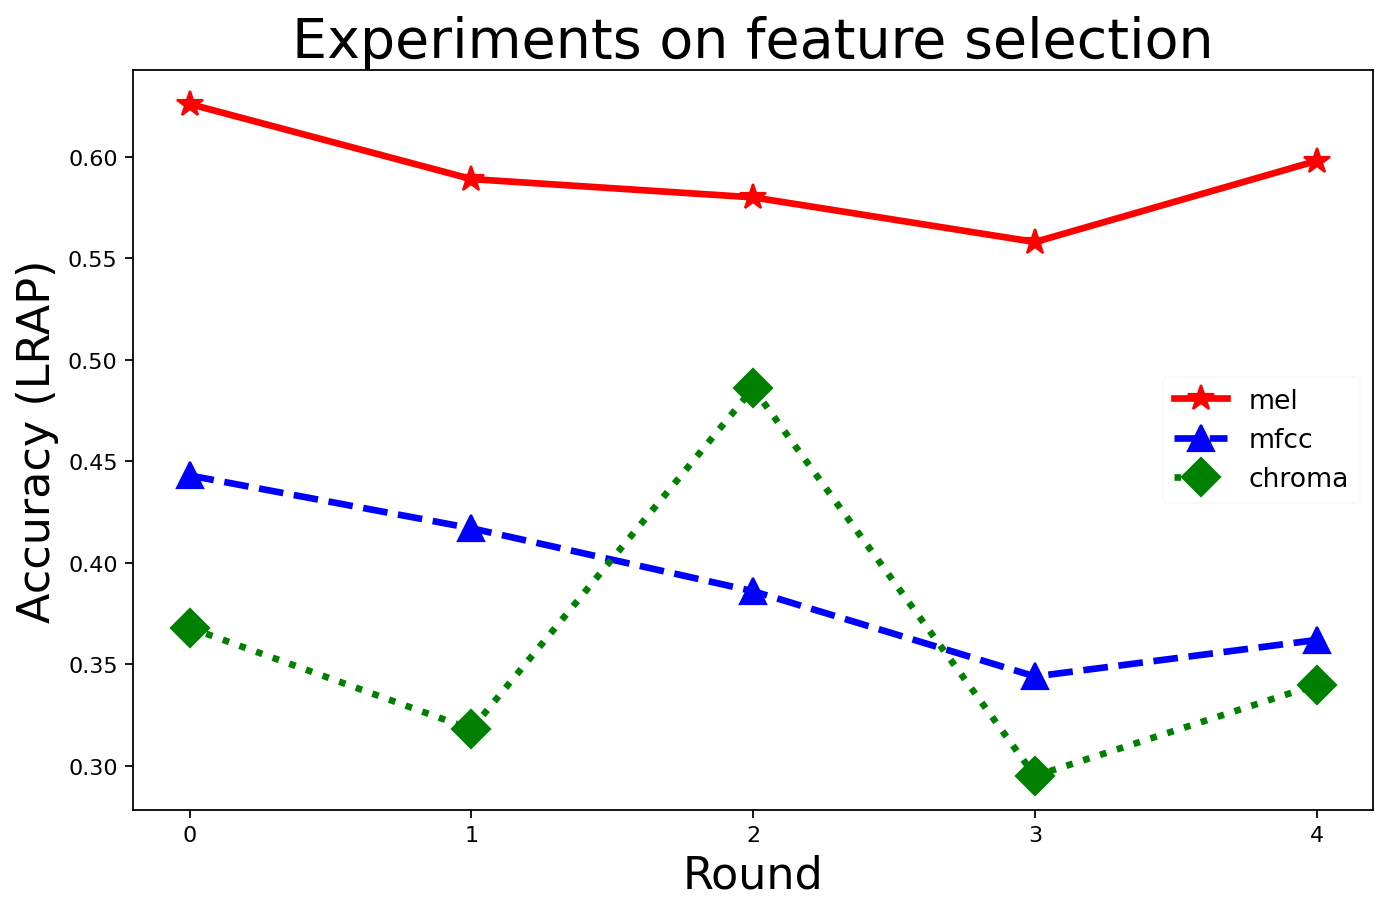

In [28]:

x = np.array([0,1,2,3,4])

plt.figure(figsize=(10,6), dpi=160)  # 设置分辨率

plt.plot(x, acc_comp_of_feats['mel'], 'r-*', linewidth=3, markersize=12, label='mel')  
plt.plot(x, acc_comp_of_feats['mfcc'], 'b--^', linewidth=3, markersize=12, label='mfcc')   
plt.plot(x, acc_comp_of_feats['chroma'], 'g:D', linewidth=3, markersize=12, label='chroma')
plt.legend(loc=0, fontsize=12, framealpha=0.1)   
plt.xticks(x, ['0', '1', '2', '3', '4'])  # 

plt.xlabel('Round', fontsize=20)         
plt.ylabel('Accuracy (LRAP)', fontsize=20)      
plt.title('Experiments on feature selection', fontsize=25)    
plt.show()

In [10]:

# only for the model selection.

model_list = ['mobilenetv3_small_050', 'tf_efficientnet_b2_ns', 'convnext_tiny_in22k'] # , 
# modify the corresponding parameters
acc_comp = {}
for each_model in model_list:
    config['model'] = each_model 
    acc_list = []*config['k_fold']

    for idx_round in range(config['k_fold']):
        new_exp_name = each_model + '_' + str(idx_round)
        config['exp_name'] = new_exp_name
        wandb.init(project="Bird", config=config, name=new_exp_name)
        wandb.config['model'] = each_model
        wandb.config['val_fold_idx'] = idx_round
        # wandb.config['epochs'] = 1 # for test
        train()

        current_best_acc = round(wandb.run.summary['best_acc'], 3)
        wandb.finish()

        acc_list.append(current_best_acc)
    acc_comp[each_model] = acc_list 



Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▃▅▅▆▆▆▆▆█
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▃▃▂▂▁▁▁▁
train_loss_step,██▇▇█▅█▇▄▇▄▃▄▇▄▃▆▆▃▃▁▂▃▂▃▂▃▂▆▂▂▄▃▄▃▁▂▆▅▂
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▃▅▅▆▅▆▆▅█
val_loss,▁▁▃▆▇▇▇███
best_acc,0.62471
epoch,9
train_loss_epoch,2.82877
train_loss_step,2.53427


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▃▆▆▇▇████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▃▃▂▂▁▁▁▁
train_loss_step,██▆▅▇▇▄▅▃▄▄▄▃▂▃▅▂▂▃▃▆▂▃▂▂▃▃▁▂▂▁▁▁▃▂▂▂▅▁▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▃▆▅▇▆█▇█▆
val_loss,▁▅▅▅█▇▇▇▇▇
best_acc,0.57818
epoch,9
train_loss_epoch,2.87382
train_loss_step,2.31722


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▄▅▅▇▇▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▃▂▂▂▂▁▁▁
train_loss_step,█▇▇▆▆▄▆▃▆▄▄▆▂▆▆▃▂▄▃▁▄▄▃▂▆▃▄▂▂▂▃▅▄▁▃▂▂▃▂▄
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▄▅▅▇▇▇██▇
val_loss,▁▅▆▆▇▇████
best_acc,0.63635
epoch,9
train_loss_epoch,2.80349
train_loss_step,3.42719


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▅▇▇██████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▃▂▂▂▁▁▁▁
train_loss_step,█▇▇▆▆▆▃▄▆▂▂▆▂▄▄▆▂▂▂▂▄▂▅▂▁▃▅▂▂▁▃▆▁▅▅▂▆▂▁▂
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▅▇▆█▇▇▇▇█
val_loss,▁▅▇██▇█▇██
best_acc,0.55962
epoch,9
train_loss_epoch,2.80039
train_loss_step,2.56468


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | MobileNetV3       | 908 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.635     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▄▆▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▃▂▂▂▁▁▁▁
train_loss_step,██▇▆▇▅▇▆▆▄▄▃▄█▅▂▄▃▆▄▃▅▂▂▄▃▃▇▁▇▄▃▂▂▂▂▂▁▇▃
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▄▆▇▆▇▇█▆█
val_loss,▁▄▅▇▇█████
best_acc,0.57143
epoch,9
train_loss_epoch,2.86612
train_loss_step,2.89177


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | EfficientNet      | 8.1 M 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.572    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▄▆▆▇▇▇▇▇█
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▂▂▁▁▁
train_loss_step,██▆█▅▅▆▄▆▆▅▄▇▃▄▅▃▃▅▅▅▅▂▆▂▂▁▃▂▂▁▆▄▁▆▂▃▃▃▅
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▄▆▆▇▇▇▇▇█
val_loss,▁▄▅█▆▄▅██▇
best_acc,0.76814
epoch,9
train_loss_epoch,1.56245
train_loss_step,2.86674


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | EfficientNet      | 8.1 M 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.572    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▅▅▆▇▇▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▂▂▂▁▁
train_loss_step,█▇▆▅▆▅▅▅▆▅▃▅▅▆▃▄▃▅▃▅▅▂▃▂▂▃▂▆▃▂▂▅▂▅▁▅▂▂▂▃
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▅▅▆▇▆▇█▇█
val_loss,▃▁▆█▆▂▅▆▅▆
best_acc,0.73369
epoch,9
train_loss_epoch,1.64116
train_loss_step,2.00046


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | EfficientNet      | 8.1 M 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.572    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▄▅▆▆▇▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▂▂▂▁▁
train_loss_step,█▇▇▆▆▇▅▅▆▃▄▃▇▃▃▃▃▂▄▄▃▃▂▃▄▄▂▆▂▅▂▆▅▂▆▂▃▃▁▅
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▄▅▆▅▇▇█▇▇
val_loss,▁▃▃▃▅▅▇█▇▆
best_acc,0.80355
epoch,9
train_loss_epoch,1.60554
train_loss_step,2.93064


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | EfficientNet      | 8.1 M 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.572    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▄▄███████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▂▂▂▁▁
train_loss_step,█▆▄▇▅▅▇▃▄▃▆▄▄▂▂▃▃▄▂▂▄▂▄▃▂▂▂▂▁▂▂▂▅▃▁▁▁▃▂▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▄▃█▆█▆▇██
val_loss,▁▃▃▅▄▇▆▇█▆
best_acc,0.71938
epoch,9
train_loss_epoch,1.65395
train_loss_step,0.88698


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | EfficientNet      | 8.1 M 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.572    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▁▅▆▆▆▇▇██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▂▂▂▁▁
train_loss_step,█▇▇▅▅▅▇▆▃▄▆▃▂▆▂▄▃▂▄▄▆▂▃▇▂▂▂▂▅▅▁▁▅▂▁▃▁▁▂▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▁▅▆▆▅▇▇█▇
val_loss,▁▄█▃▆▁▃▅▆▅
best_acc,0.73515
epoch,9
train_loss_epoch,1.59462
train_loss_step,0.96838


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | ConvNeXt          | 28.1 M
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
112.372   Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▁▂▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▃▃▂▂▂▁▁▁▁
train_loss_step,▆▇▇▅▄▄▄█▆▄▇▄▇▅▄█▅▇▃▂▃▅▅▇█▆▄▄▇▄▅▃▂▁▇▇▇▄▃▅
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▂▁▃▇▇▆▄█▇█
val_loss,▁▂▄▅▆▇████
best_acc,0.13611
epoch,9
train_loss_epoch,4.87495
train_loss_step,4.9116


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | ConvNeXt          | 28.1 M
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
112.372   Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▁████████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▃▃▂▂▂▁▁▁▁
train_loss_step,▄▆█▅▇█▄▅▅▅▆▆▄▂▃▄▇▅▅▁▅▃▄▆▆▆▃▃▂▅▅▇▆▄▄▅▆▅▂▄
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▃▁█▄▃▁▄▂▂▂
val_loss,▁▂▄▅▆▇▇▇██
best_acc,0.14177
epoch,9
train_loss_epoch,4.87325
train_loss_step,4.7811


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | ConvNeXt          | 28.1 M
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
112.372   Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▁▁▁▁▁▁███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▃▃▂▂▂▂▁▁▁
train_loss_step,▅▅▇▅▆▅▄▃▄▃▂▂▄▃▅▅▃▅▂▅▅▃▅▄▆▄▅▃▂▆▇▅▁▂▅▁▄▂█▄
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▆▃▅▁▂▃▄█▃▅
val_loss,▁▃▅▆▆█▇███
best_acc,0.17111
epoch,9
train_loss_epoch,4.86716
train_loss_step,4.87606


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | ConvNeXt          | 28.1 M
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
112.372   Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▃▃▂▂▂▂▁▁▁
train_loss_step,▄▄▃▇▅▃▄▅▇▅▄▅▆▃▅▆▁▄▆█▃▆▁▇▅▆▃▅▆▅▅▄▅█▄▆██▃▃
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,█▅▅▂▄▁▃▁▁▁
val_loss,▁▂▃▅▆▇████
best_acc,0.11498
epoch,9
train_loss_epoch,4.8659
train_loss_step,4.6835


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | ConvNeXt          | 28.1 M
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
112.372   Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

best_acc,▁█████████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▄▃▃▂▂▂▁▁▁
train_loss_step,█▄▆▆▅▇▃▄▄▂▅▅▅▅▆▅▆▅▆▄▄▄▄▄▅▇▄▄▅▆▆▅▃▄▅▅▅▅▅▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▃█▅▂▃▅▂▂▁▁
val_loss,▁▂▃▅▆▇▇███
best_acc,0.12829
epoch,9
train_loss_epoch,4.87171
train_loss_step,4.39916


### Quantitative comparison of various Deep learning-based backbone


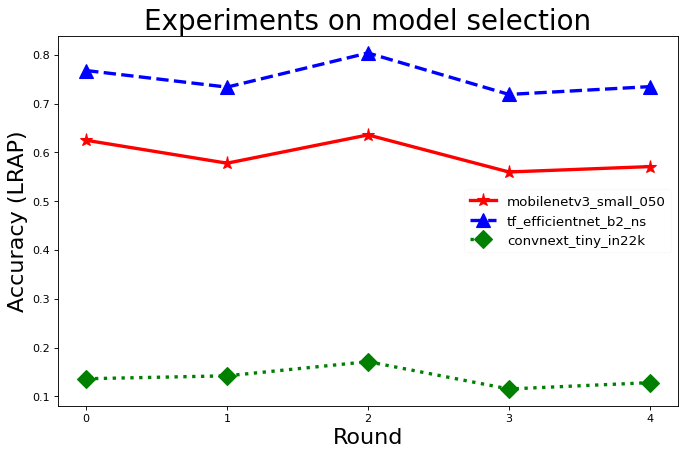

In [115]:
data = acc_comp 
x = np.array([0,1,2,3,4])

plt.figure(figsize=(10,6), dpi=80)  

plt.plot(x, data['mobilenetv3_small_050'], 'r-*', linewidth=3, markersize=12, label='mobilenetv3_small_050')  
plt.plot(x, data['tf_efficientnet_b2_ns'], 'b--^', linewidth=3, markersize=12, label='tf_efficientnet_b2_ns')   
plt.plot(x, data['convnext_tiny_in22k'], 'g:D', linewidth=3, markersize=12, label='convnext_tiny_in22k')
plt.legend(loc=0, fontsize=12, framealpha=0.1)   
plt.xticks(x, ['0', '1', '2', '3', '4'])  # 

plt.xlabel('Round', fontsize=20)         
plt.ylabel('Accuracy (LRAP)', fontsize=20)      
plt.title('Experiments on model selection', fontsize=25)    
plt.show()

### Porject Extra Method: Swin Transformer
Let's take the mel-spectrum data as an example. The original size of the data (height and width) is [128, 313]. However, we need to resize the data to a fixed size of [224, 224] because the Swin Transformer splits the input 2D data into several local windows with a fixed size.

In [30]:
new_exp_name = 'swin_tiny_mel_data'
wandb.init(project="Bird", config=config, name=new_exp_name)
wandb.config['model'] = 'swin_tiny_patch4_window7_224' 
wandb.config['exp_name'] = new_exp_name
wandb.config['epochs'] = 10 # for test

train(data=mel_data)

# wandb.finish()

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | SwinTransformer   | 27.7 M
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
27.7 M    Trainable params
0         Non-trainable params
27.7 M    Total params
110.889   Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [33]:
print('The accuracy of Swin Transformer is : ', round(wandb.run.summary['best_acc'], 3))

The accuracy of Swin Transformer is :  0.135


In [34]:
# Final one
new_exp_name = 'tf_efficientnet__final'
wandb.init(project="Bird", config=config, name=new_exp_name)
wandb.config['model'] = 'tf_efficientnet_b3_ns' 
wandb.config['exp_name'] = new_exp_name
wandb.config['epochs'] = 50 # for test

train(data=mel_data)

best_acc,▁▁▃███████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▄▃▃▂▂▁▁
train_loss_step,█▁▇▅▆▄▅▃▄▃▅▅▆▂▂▃▄▇▆▅▁▂▃▅▃▂▆▃▂▂▄▃▄▂▁▃▄▁▃▆
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▅▁▆█▂▂▆▅▄▅
val_loss,▁▂▃▄▅▇▇███
best_acc,0.13463
epoch,9
train_loss_epoch,4.76764
train_loss_step,4.99561


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | EfficientNet      | 11.2 M
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.688    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]